In [1]:
import json
import torch
import random

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torchinfo import summary
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from sklearn.preprocessing import MinMaxScaler

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [3]:
def process_data(file_path):
    with open(file_path, "r") as file:
        datas = json.load(file)

    dataset = []
    for data in datas:
        user_info = []
        for _, value in data["user_info"].items():
            if value:
                user_info.append(value)
            else:
                user_info.append(-1)
        
        parameter = []
        for _, value in data["parameter"].items():
            parameter.append(value)
        dataset.append({"user_info": user_info, "parameter": parameter})

    return dataset

In [4]:
class HearingAidDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()
        
        # 提前将参数归一化
        params = [item["parameter"] for item in dataset]
        self.scaled_params = self.scaler.fit_transform(params)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        user_info = self.dataset[idx]["user_info"]
        user_info_tensor = torch.tensor(user_info, dtype=torch.float32)
        param_tensor = torch.tensor(self.scaled_params[idx], dtype=torch.float32)
        
        return user_info_tensor, param_tensor

In [5]:
# class HearingAidDataset(Dataset):
#     def __init__(self, dataset):
#         self.dataset = dataset

#     def __len__(self):
#         return len(self.dataset)
    
#     def __getitem__(self, idx):
#         user_info = self.dataset[idx]["user_info"]
#         param = self.dataset[idx]["parameter"]
#         user_info_tensor = torch.tensor(user_info, dtype=torch.float32)
#         param_tensor = torch.tensor(param, dtype=torch.float32)
        
#         return user_info_tensor, param_tensor

In [6]:
# class HearingAidModel(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(HearingAidModel, self).__init__()
#         self.input_layer = nn.Linear(input_size, 128)
#         self.relu1 = nn.ReLU()
#         self.input_bn = nn.BatchNorm1d(128)
#         self.hidden_layer1 = nn.Linear(128, 256)
#         self.relu2 = nn.ReLU()
#         self.hidden_bn1 = nn.BatchNorm1d(256)
#         self.hidden_layer2 = nn.Linear(256, 128)
#         self.relu3 = nn.ReLU()
#         self.hidden_bn2 = nn.BatchNorm1d(128)
#         self.output_layer = nn.Linear(128, output_size)
#         self.dropout = nn.Dropout(0.2)
    
#     def forward(self, x):
#         x = self.input_layer(x)
#         x = self.relu1(x)
#         x = self.input_bn(x)
#         x = self.hidden_layer1(x)
#         x = self.relu2(x)
#         x = self.hidden_bn1(x)
#         x = self.hidden_layer2(x)
#         x = self.relu3(x)
#         x = self.hidden_bn2(x)
#         x = self.output_layer(x)
#         return x

In [7]:
class HearingAidModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(HearingAidModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(128, 256)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(256, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        return x

In [8]:
train_path = "../../train_data/type_1/train.json"
valid_path = "../../train_data/type_1/valid.json"

train_dataset = process_data(train_path)
valid_dataset = process_data(valid_path)

In [9]:
# 超参数
batch_size = 64
learning_rate = 0.0001
num_epochs = 100

In [10]:
# 初始化模型
input_size = len(train_dataset[0]["user_info"])
output_size = len(train_dataset[0]["parameter"])
model = HearingAidModel(input_size, output_size).to(DEVICE)
summary(model, input_size=(batch_size, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
HearingAidModel                          [64, 119]                 --
├─Linear: 1-1                            [64, 128]                 7,936
├─ReLU: 1-2                              [64, 128]                 --
├─Linear: 1-3                            [64, 256]                 33,024
├─ReLU: 1-4                              [64, 256]                 --
├─Linear: 1-5                            [64, 119]                 30,583
Total params: 71,543
Trainable params: 71,543
Non-trainable params: 0
Total mult-adds (M): 4.58
Input size (MB): 0.02
Forward/backward pass size (MB): 0.26
Params size (MB): 0.29
Estimated Total Size (MB): 0.56

In [11]:
train_dataset = HearingAidDataset(train_dataset)
valid_dataset = HearingAidDataset(valid_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [12]:
# 测试模型输出
for user_info, param in train_loader:
    user_info = user_info.to(DEVICE)
    print(user_info.shape)
    param = param.to(DEVICE)
    output = model(user_info)
    print(output)
    break

torch.Size([64, 61])
tensor([[  0.5282,  -1.1199,   0.2262,  ...,   0.2745,   0.3481,   0.8670],
        [ -3.1613,  -6.6161,  -4.8263,  ...,   4.7747,   0.4891,  -4.2064],
        [ -2.7869,  -5.9963,  -5.6155,  ...,   3.3619,   0.7696,  -4.7101],
        ...,
        [ -4.2020, -10.0818,  -7.0336,  ...,   5.7964,   2.1514,  -5.4858],
        [ -3.4194,  -8.9265,  -5.2155,  ...,   4.4228,   1.2709,  -5.0194],
        [  0.4680,  -5.6077,  -2.1143,  ...,   1.2142,  -0.4570,  -3.2847]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [13]:
criterion = nn.L1Loss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 

In [14]:
# Early stopping 参数
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
valid_losses = []

# 训练轮数
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for user_info, param in train_loader:
        user_info = user_info.to(DEVICE)
        param = param.to(DEVICE)

        optimizer.zero_grad()
        output = model(user_info)
        loss = criterion(output, param)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # 验证步骤
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for user_info, param in valid_loader:
            user_info = user_info.to(DEVICE)
            param = param.to(DEVICE)
            output = model(user_info)
            val_loss = criterion(output, param)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(valid_loader)
    valid_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}")
    
    # 早停检查
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../models/test.pth')  # 保存最佳模型
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break
    
    scheduler.step()  # 更新学习率

print("Training complete. Best Validation Loss: {:.3f}".format(best_val_loss))

Epoch 1, Training Loss: 0.989, Validation Loss: 0.546
Epoch 2, Training Loss: 0.448, Validation Loss: 0.386
Epoch 3, Training Loss: 0.333, Validation Loss: 0.307
Epoch 4, Training Loss: 0.270, Validation Loss: 0.259
Epoch 5, Training Loss: 0.229, Validation Loss: 0.225
Epoch 6, Training Loss: 0.202, Validation Loss: 0.203
Epoch 7, Training Loss: 0.182, Validation Loss: 0.185
Epoch 8, Training Loss: 0.167, Validation Loss: 0.174
Epoch 9, Training Loss: 0.155, Validation Loss: 0.162
Epoch 10, Training Loss: 0.147, Validation Loss: 0.155
Epoch 11, Training Loss: 0.141, Validation Loss: 0.155
Epoch 12, Training Loss: 0.141, Validation Loss: 0.154
Epoch 13, Training Loss: 0.140, Validation Loss: 0.153
Epoch 14, Training Loss: 0.139, Validation Loss: 0.153
Epoch 15, Training Loss: 0.138, Validation Loss: 0.152
Epoch 16, Training Loss: 0.138, Validation Loss: 0.151
Epoch 17, Training Loss: 0.137, Validation Loss: 0.151
Epoch 18, Training Loss: 0.137, Validation Loss: 0.150
Epoch 19, Training 

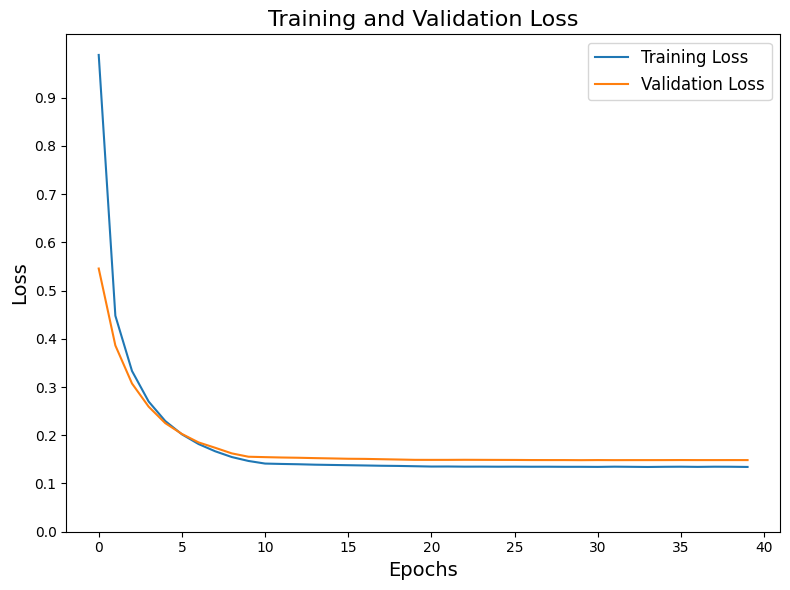

In [24]:
# Draw the loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

y_ticks = np.arange(0, 1, 0.1)  # 设置刻度间隔为 0.5
plt.yticks(y_ticks)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
# 加载模型
model.load_state_dict(torch.load('../models/test.pth'))
model.eval()

HearingAidModel(
  (fc1): Linear(in_features=61, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=256, out_features=119, bias=True)
)

In [17]:
def predict(sample):
    user_info = sample["user_info"]
    real = sample["parameter"]
    scaler = MinMaxScaler()
    _ = scaler.fit_transform([real])

    user_info_tensor = torch.tensor(user_info, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        pred = model(user_info_tensor)
        pred = scaler.inverse_transform(pred.cpu().numpy())[0]

    return real, pred

In [18]:
test_path = "../../train_data/type_1/test.json"
test_dataset = process_data(test_path)

sample = random.choice(test_dataset)
real, pred = predict(sample)

# calculate the accuracy
correct = 0
for a, b in zip(real, pred):
    if  abs(a - b) <= 1:
        correct += 1
print(f"Accuracy: {correct / len(real) * 100:.2f}%")

results = pd.DataFrame({
    '真实值': real,
    '预测值': pred,
})

results

Accuracy: 100.00%


,真实值,预测值
0,2,1.963503
1,25,25.595570
2,21,21.191755
3,21,21.435606
4,21,21.269693
...,...,...
114,70,70.786079
115,10,10.741396
116,12,12.161856
117,6,6.638809


In [19]:
accuracy = []
for item in test_dataset:
    if item["user_info"]:
        reals, preds = predict(item)
        correct = 0
        for i, real, pred in zip(range(119), reals, preds):
            if abs(real - pred) <= 1:
                correct += 1
        accuracy.append(correct / len(reals))

print(f"Average Accuracy: {sum(accuracy) / len(accuracy) * 100:.2f}%")

Average Accuracy: 99.02%


In [20]:
# 统计误差
errors = [[] for _ in range(119)]

for item in test_dataset:
    if item["user_info"]:
        reals, preds = predict(item)
        reals, preds = list(reals), list(preds)
        accepted_error = []
        for i in range(119):
            errors[i].append(reals[i] - preds[i])


# 计算每个维度可接受的误差范围：数值位于范围外1.5×IQR 到 3×IQR范围的数值，称作适度离群值（mild outlier）
acceptable_errors = []
for error in errors:
    error = pd.Series(error)
    Q1 = error.quantile(0.25)
    Q3 = error.quantile(0.75)
    IQR = Q3 - Q1
    acceptable_error = (Q1 - 3 * IQR, Q3 + 3 * IQR)
    acceptable_errors.append(acceptable_error)

acceptable_errors[0]

(-0.5322510600090027, 0.1546587496995926)

In [21]:
accuracy = []
for item in test_dataset:
    if item["user_info"]:
        reals, preds = predict(item)
        correct = 0
        for i, real, pred in zip(range(119), reals, preds):
            x, y = acceptable_errors[i]
            if x <= real - pred <= y:
                correct += 1
        accuracy.append(correct / len(reals))

print(f"Average Accuracy: {sum(accuracy) / len(accuracy) * 100:.2f}%")

Average Accuracy: 99.81%


In [22]:
# # 每个维度的箱型图
# datas_1 = []
# datas_2 = []

# for item in test_dataset:
#     if item["user_info"]:
#         reals, preds = predict(item)
#         reals, preds = list(reals), list(preds)
#         datas_1.append(reals[0] - preds[0])
#         datas_2.append(reals[1] - preds[1])

# # plot the boxplot, 
# plt.figure(figsize=(10, 6))
# plt.boxplot([datas_1, datas_2], patch_artist=True, showmeans=True)
# plt.xticks([1, 2], ['Dimension 1', 'Dimension 2'])
# plt.ylabel('Error')
# plt.title('Error of each dimension')
# plt.grid(axis='y')
# plt.show()

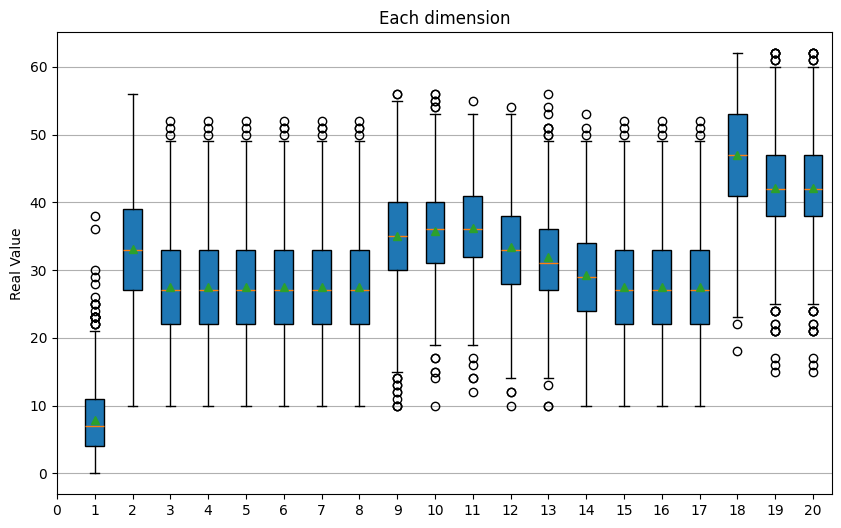

In [23]:
datas_real = [[] for _ in range(119)]
datas_pred = [[] for _ in range(119)]

for item in test_dataset:
    if item["user_info"]:
        reals, preds = predict(item)
        reals, preds = list(reals), list(preds)
        for i in range(119):
            datas_real[i].append(reals[i])
            datas_pred[i].append(preds[i])

# plot the boxplot 
plt.figure(figsize=(10, 6))
plt.boxplot(datas_real[:20], patch_artist=True, showmeans=True)
plt.xticks([_ for _ in range(21)], [_ for _ in range(21)])
plt.ylabel('Real Value')
plt.title('Each dimension')
plt.grid(axis='y')
plt.show()